In [1]:
import pandas as pd
import scipy.stats as stats
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import os

### Data Loading and Caching
- Caching optimizes the loading of the dataset by checking if a cached version exists. If so, it loads it; otherwise, it reads from the CSV and caches it.

In [2]:
def load_data(csv_file='marketing_AB.csv', pickle_file='marketing_AB.pkl'):
    """
    Loads the dataset efficiently using caching.
    If a cached Pickle file exists, it loads from there; otherwise, it reads from CSV and caches it.
    """
    if os.path.exists(pickle_file):
        print("Loading from cached Pickle file...")
        df = pd.read_pickle(pickle_file)
    else:
        print("Loading from CSV and caching...")
        df = pd.read_csv(csv_file)
        df.to_pickle(pickle_file)  # Cache the dataset
    return df

df = load_data()
print(df.head())  
df.shape

Loading from cached Pickle file...
   Unnamed: 0  user id test group  converted  total ads most ads day  \
0           0  1069124         ad      False        130       Monday   
1           1  1119715         ad      False         93      Tuesday   
2           2  1144181         ad      False         21      Tuesday   
3           3  1435133         ad      False        355      Tuesday   
4           4  1015700         ad      False        276       Friday   

   most ads hour  
0             20  
1             22  
2             18  
3             10  
4             14  


(588101, 7)

### Data Cleaning and Feature Engineering

In [3]:
df.isnull().sum()

Unnamed: 0       0
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

In [4]:
df.duplicated().sum()

0

In [5]:
df['converted'] = df['converted'].astype(int) 

In [6]:
df['conversion_rate'] = df['converted'] / df['total ads']

In [7]:
conversion_rate_ad = df[df['test group'] == 'ad']['conversion_rate'].mean()
print("Average Conversion Rate for 'ad' Group:", conversion_rate_ad)

Average Conversion Rate for 'ad' Group: 0.0009235262133625706


The 'ad' group's conversion rate of 0.00092 is low, meaning only a small fraction of users are converting. This indicates potential inefficiencies in the ad campaign that may require optimization.

In [8]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour,conversion_rate
0,0,1069124,ad,0,130,Monday,20,0.0
1,1,1119715,ad,0,93,Tuesday,22,0.0
2,2,1144181,ad,0,21,Tuesday,18,0.0
3,3,1435133,ad,0,355,Tuesday,10,0.0
4,4,1015700,ad,0,276,Friday,14,0.0


### Descriptive Statistics

In [9]:
df.describe()

,Unnamed: 0,user id,converted,total ads,most ads hour,conversion_rate
count,588101.000000,5.881010e+05,588101.000000,588101.000000,588101.000000,588101.000000
mean,294050.000000,1.310692e+06,0.025239,24.820876,14.469061,0.000920
std,169770.279667,2.022260e+05,0.156850,43.715181,4.834634,0.015811
min,0.000000,9.000000e+05,0.000000,1.000000,0.000000,0.000000
25%,147025.000000,1.143190e+06,0.000000,4.000000,11.000000,0.000000
50%,294050.000000,1.313725e+06,0.000000,13.000000,14.000000,0.000000
75%,441075.000000,1.484088e+06,0.000000,27.000000,18.000000,0.000000
max,588100.000000,1.654483e+06,1.000000,2065.000000,23.000000,1.000000


In [12]:
df.groupby(by='test group')["converted"].describe()

,count,mean,std,min,25%,50%,75%,max
test group,,,,,,,,
ad,564577.0,0.025547,0.157778,0.0,0.0,0.0,0.0,1.0
psa,23524.0,0.017854,0.132424,0.0,0.0,0.0,0.0,1.0


In [13]:
df.groupby(by='test group')["total ads"].describe()

,count,mean,std,min,25%,50%,75%,max
test group,,,,,,,,
ad,564577.0,24.823365,43.750456,1.0,4.0,13.0,27.0,2065.0
psa,23524.0,24.761138,42.860720,1.0,4.0,12.0,26.0,907.0


In [14]:
print(df.shape)
df.dropna(subset=['total ads'], inplace=True)
print(df.shape)

(588101, 8)
(588101, 8)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       588101 non-null  int64  
 1   user id          588101 non-null  int64  
 2   test group       588101 non-null  object 
 3   converted        588101 non-null  int32  
 4   total ads        588101 non-null  int64  
 5   most ads day     588101 non-null  object 
 6   most ads hour    588101 non-null  int64  
 7   conversion_rate  588101 non-null  float64
dtypes: float64(1), int32(1), int64(4), object(2)
memory usage: 33.7+ MB


In [19]:
# Split the data into two groups: ad and psa
ad_group = df[df['test group'] == 'ad']
psa_group = df[df['test group'] == 'psa']

# Verify the size of each group
print("Ad group size:", ad_group.shape)
print("PSA group size:", psa_group.shape)

Ad group size: (564577, 8)
PSA group size: (23524, 8)


In [20]:
# Calculate conversion rates for ad and psa groups
conversion_rate_ad = ad_group['converted'].mean()
conversion_rate_psa = psa_group['converted'].mean()

print(f"Conversion Rate for 'ad' Group: {conversion_rate_ad:.4f}")
print(f"Conversion Rate for 'PSA' Group: {conversion_rate_psa:.4f}")

Conversion Rate for 'ad' Group: 0.0255
Conversion Rate for 'PSA' Group: 0.0179


- The 'ad' group has more users (564,577 vs 23,524) and a higher conversion rate (0.0255 vs 0.0179). This shows that the 'ad' campaign is more successful in driving user action than the PSA campaign.

### Hypothesis Testing

#### Null Hypothesis
- Null Hypothesis (H0): The test groups (ad vs. control) show no difference in conversion rates.
- Alternative Hypothesis (H1): The test groups (ad vs. control) show a significant difference in conversion rates.

In [21]:
t_stat, p_value = stats.ttest_ind(ad_group['converted'], psa_group['converted'])

# Output the t-statistic and p-value
print("T-statistic:", t_stat)
print("P-value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis: Significant difference in conversion rates.")
else:
    print("Fail to reject the null hypothesis: No significant difference in conversion rates.")

T-statistic: 7.37040597428566
P-value: 1.7033052627831264e-13
Reject the null hypothesis: Significant difference in conversion rates.


The T-statistic is 7.37, and the p-value is extremely small (1.7e-13). As the p-value is less than 0.05, we reject the null hypothesis and conclude there is a significant difference in conversion rates.

### Data Visualization

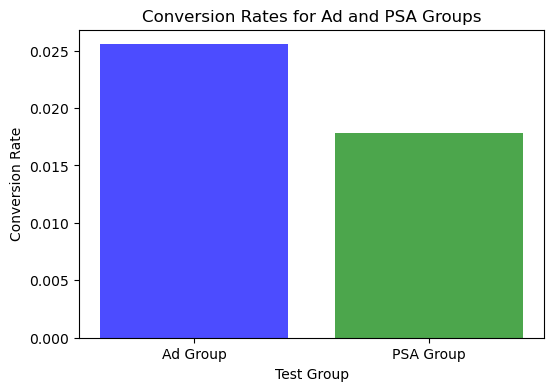

In [22]:
conversion_rates = [conversion_rate_ad, conversion_rate_psa]
groups = ['Ad Group', 'PSA Group']

plt.figure(figsize=(6, 4))
plt.bar(groups, conversion_rates, color=['blue', 'green'], alpha=0.7)
plt.title("Conversion Rates for Ad and PSA Groups")
plt.xlabel("Test Group")
plt.ylabel("Conversion Rate")
plt.show()

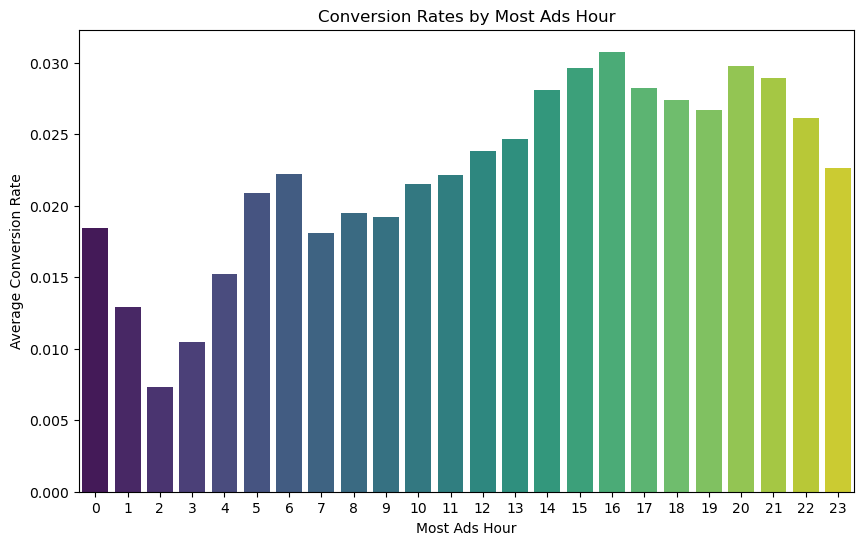

In [27]:
# Group by most ads hour and calculate the mean conversion rate
conversion_by_hour = df.groupby('most ads hour')['converted'].mean().reset_index()

# Plot the conversion rates by hour
plt.figure(figsize=(10, 6))
sns.barplot(x='most ads hour', y='converted', data=conversion_by_hour, palette='viridis')
plt.title('Conversion Rates by Most Ads Hour')
plt.xlabel('Most Ads Hour')
plt.ylabel('Average Conversion Rate')
plt.show()

### Logistic Regression Model

              Coefficient
total ads        0.010159
test group      -0.388269
most ads day     0.015424


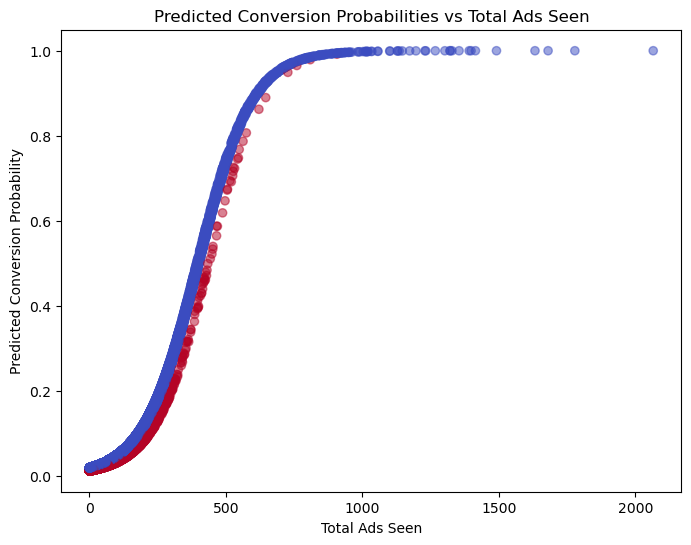

In [23]:
# Encode categorical variables
label_encoder = LabelEncoder()
df['test group'] = label_encoder.fit_transform(df['test group'])
df['most ads day'] = label_encoder.fit_transform(df['most ads day'])

# Features: Total Ads, Test Group, Most Ads Day
X = df[['total ads', 'test group', 'most ads day']]
y = df['converted']

# Fit logistic regression model
logreg = LogisticRegression()
logreg.fit(X, y)

# Get model coefficients
coefficients = pd.DataFrame(logreg.coef_.T, index=X.columns, columns=['Coefficient'])
print(coefficients)

# Predict probabilities
df['predicted_prob'] = logreg.predict_proba(X)[:, 1]

# Plot predicted probabilities vs actual conversion rates
plt.figure(figsize=(8, 6))
plt.scatter(df['total ads'], df['predicted_prob'], c=df['test group'], cmap='coolwarm', alpha=0.5)
plt.title("Predicted Conversion Probabilities vs Total Ads Seen")
plt.xlabel("Total Ads Seen")
plt.ylabel("Predicted Conversion Probability")
plt.show()

- The coefficients from the logistic regression model indicate the impact of each feature. The plot shows the predicted conversion probabilities versus the number of ads seen.

### Power Analysis
- Power analysis is performed to evaluate the sensitivity of the test and ensure it is capable of detecting a significant effect, if present.

In [25]:
# Using statsmodels to compute power analysis
from statsmodels.stats.power import TTestIndPower
analysis = TTestIndPower()
power = analysis.power(effect_size=0.5, nobs1=100, ratio=1, alpha=0.05)
print("Power of the test:", power)

Power of the test: 0.9404271933839895


- The power of the test is calculated to be 0.94, which indicates a high likelihood of detecting a significant difference in conversion rates if one exists.